# Importações

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import inflection
import pickle
from IPython.display import Image
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('darkgrid')

In [2]:
def ml_error(model_name, y_test, yhat):
    mae = (np.sum(np.abs(np.expm1(y_test) - np.expm1(yhat))))/len(np.expm1(yhat))
    mape = np.sum(np.abs(np.expm1(y_test) - np.expm1(yhat))/np.expm1(yhat))/len(yhat)
    rmse = np.sqrt((np.sum((np.expm1(y_test) - np.expm1(yhat))**2))/len(np.expm1(yhat)))
    #mae = mean_absolute_error(np.expm1(y_test),np.expm1(yhat))
    #mape = mean_absolute_percentage_error(np.expm1(y_test),np.expm1(yhat))
    #rmse = mean_squared_error(np.expm1(y_test),np.expm1(yhat))  
    
    return {'Model name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse}

def cross_validation(x_training, kfold, model_name, model):
    l_mae = []
    l_mape = []
    l_rmse = []

    for k in range(kfold,0,-1):
        start_validation = x_training['date'].max() - datetime.timedelta(days=6*7*k)
        end_validation = x_training['date'].max() - datetime.timedelta(days=6*7*(k-1))
        
        training = x_training[x_training['date'] < start_validation]
        validation = x_training[(x_training['date'] >= start_validation) & (x_training['date'] <= end_validation)]
        
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']
        
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']
        
        m = model.fit(xtraining, ytraining)
        yhat = m.predict(xvalidation)
        
        m_result = ml_error(model_name, yvalidation, yhat)
        
        mae = (np.sum(np.abs(np.expm1(yvalidation) - np.expm1(yhat))))/len(np.expm1(yhat))
        mape = np.sum(np.abs(np.expm1(yvalidation) - np.expm1(yhat))/np.expm1(yhat))/len(yhat)
        rmse = np.sqrt((np.sum((np.expm1(yvalidation) - np.expm1(yhat))**2))/len(np.expm1(yhat)))
        #mae = mean_absolute_error(np.expm1(y_test_temp),np.expm1(yhat))
        #mape = mean_absolute_percentage_error(np.expm1(y_test_temp),np.expm1(yhat))
        #rmse = mean_squared_error(np.expm1(y_test_temp),np.expm1(yhat))  
        l_mae.append(mae)
        l_mape.append(mape)
        l_rmse.append(rmse)
        
        
    return {'Model Name':model_name,
            'MAE CV':np.round(np.mean(l_mae),2).astype(str) + ' +/- ' + np.round(np.std(l_mae),2).astype(str),
            'MAPE CV':np.round(np.mean(l_mape),2).astype(str) + ' +/- ' + np.round(np.std(l_mape),2).astype(str),
            'RMSE CV':np.round(np.mean(l_rmse),2).astype(str) + ' +/- ' + np.round(np.std(l_rmse),2).astype(str)}

# 1. Carregamento dos dados

In [3]:
df_sales = pd.read_csv('data/train.csv', low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)

In [4]:
df1 = pd.merge(df_sales, df_store, how='left', on='Store')

In [5]:
df1.sample(50).head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
154158,289,7,2015-03-15,0,0,0,0,0,0,d,a,6540.0,12.0,2007.0,0,NaN,NaN,NaN
42876,507,2,2015-06-23,6315,528,1,0,0,0,a,c,9070.0,4.0,2011.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
238147,994,2,2014-12-30,6095,570,1,0,0,1,a,a,2290.0,7.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
705889,880,1,2013-10-07,9660,941,1,1,0,0,a,c,4570.0,NaN,NaN,0,NaN,NaN,NaN
789162,528,3,2013-07-24,7699,765,1,0,0,1,a,c,20620.0,NaN,NaN,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 2. Descrição dos dados

In [6]:
df2 = df1.copy()

In [7]:
snakecase = lambda x: inflection.underscore(x)
df2.columns = list(map(snakecase, df1.columns))

In [8]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1017209
Number of columns: 18


In [9]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df2['date'] = pd.to_datetime(df2['date'])

In [11]:
(df2.isna().sum()/len(df1))*100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

In [12]:
### Preenchendo NAs

In [13]:
df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
df2['promo2_since_week'] = df2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
df2['promo2_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [14]:
calendar = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['promo_interval'].fillna(0, inplace=True)
df2['calendar'] = df2['date'].dt.month.map(calendar)
df2['is_promo'] = df2[['promo_interval','calendar']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['calendar'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
calendar                                object
is_promo                                 int64
dtype: object

In [16]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

In [17]:
### Estatística Descritiva

In [18]:
num_features = df2.select_dtypes(include=['int64','float64'])
cat_features = df2.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [19]:
#Mean, Median
df2_mean = pd.DataFrame(num_features.apply(lambda x: x.mean())).T
df2_median = pd.DataFrame(num_features.apply(lambda x: x.median())).T

#min, max, range, STD, skew, kurtosis
df2_min = pd.DataFrame(num_features.apply(lambda x: x.min())).T
df2_max = pd.DataFrame(num_features.apply(lambda x: x.max())).T
df2_range = pd.DataFrame(num_features.apply(lambda x: x.max()-x.min())).T
df2_std = pd.DataFrame(num_features.apply(np.std)).T
df2_skew = pd.DataFrame(num_features.apply(lambda x: x.skew())).T
df2_kurtosis = pd.DataFrame(num_features.apply(lambda x: x.kurtosis())).T

In [20]:
df2_ds = pd.concat([df2_min, df2_max, df2_range, df2_mean, df2_median, df2_std, df2_skew, df2_kurtosis]).T.reset_index()
df2_ds.columns = ['features','min','max','range','mean','median','std','skew','kurtosis']
df2_ds

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


<Figure size 1080x360 with 0 Axes>

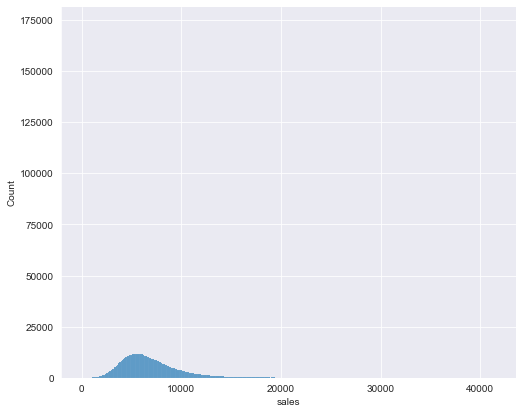

In [21]:
plt.figure(figsize=(15,5))
ax = sns.displot(df2['sales'])
ax.fig.set_size_inches(8,6)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

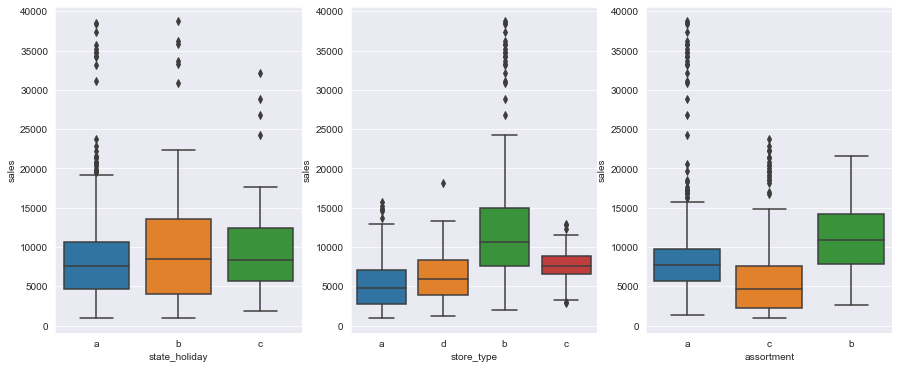

In [22]:
df_temp = df2[(df2['state_holiday'] != '0') & (df2['sales'] >0)]

plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=df_temp)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=df_temp)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=df_temp)

# 3. Feature Engeneering

In [23]:
df3 = df2.copy()

In [24]:
### Mapa mental

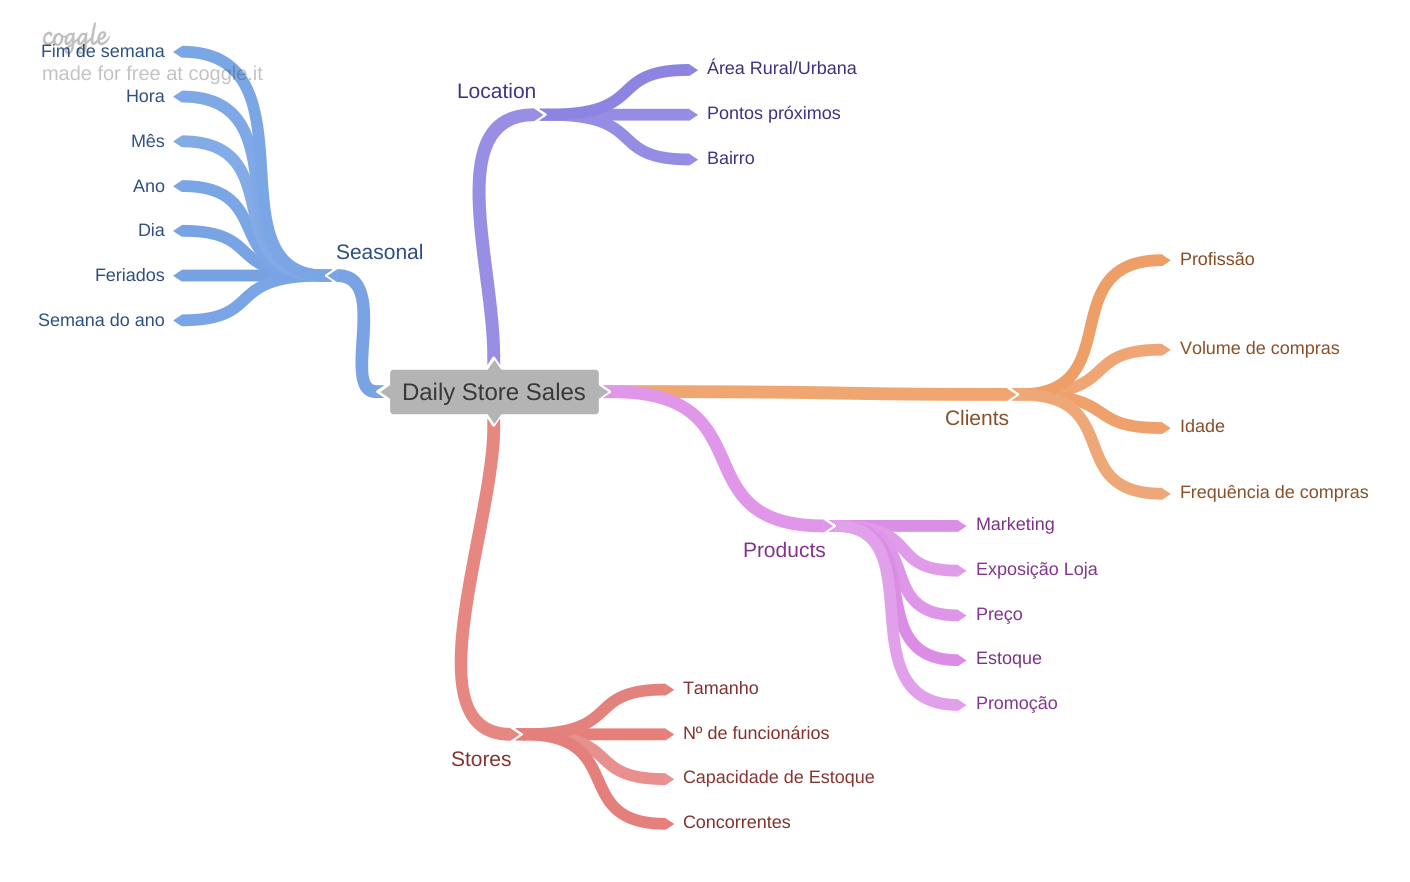

In [25]:
Image('mind_map.png')

In [26]:
### Criação de Hipóteses

In [27]:
#Minhas
#1. Lojas com maior número de sortimento vendem mais.
#2. Lojas com competidores mais proximos vendem menos.
#3. As vendas são maiores nos fins de semana.
#4. Lojas em produção vendem mais.

In [28]:
#Meigarom
#1 Lojas com maior sortimentos vendem mais
#2 Lojas com competidores mais próximos vendem menos
#3 Lojas com competidores a mais tempo vendem mais
#4 Lojas com promoções ativas por mais tempo vendem mais
#5 Lojas com mais dias de promoção vendem mais
#6 Lojas com mais promocoes consecutivas vendem mais
#7 Lojas abertas durante o feriado de natal vendem mais
#8 Lojas vendem mais ao longo dos anos
#9 Lojas devem vender mais no segundo semestre do ano
#10 Lojas devem vender mais depois do dia 10 de cada mês
#11 Lojas devem vender menos aos finais de semana
#12 Lojas devem vender menos durante os feriados escolares

In [29]:
### Criação de variáveis

In [30]:
#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week

#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

#competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df3['competition_time_month'] = ((df3['date'] - df3['competition_since'])/30).apply(lambda x: x.days).astype(int)
#promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo_time_week'] = ((df3['date'] - df3['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [31]:
df3.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4. Filtragem de Variáveis

In [32]:
df4 = df3.copy()

In [33]:
df4.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [34]:
### Seleção de Linhas
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]
### Seleção de Colunas
df4.drop(['customers','open','promo_interval','calendar'], axis=1, inplace=True)

# 5. Análise Exploratória de Dados (EDA)

In [35]:
df5 = df4.copy()

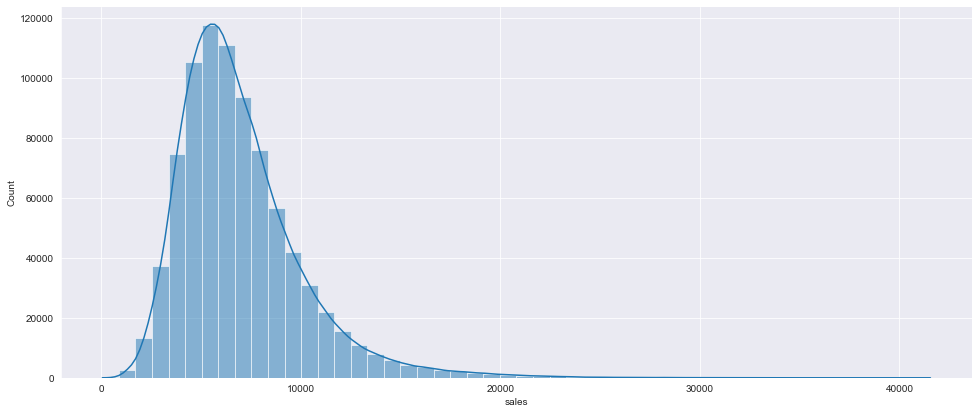

In [36]:
#Análise Univariada
g = sns.displot(df5['sales'], bins=50, kde=True)
g.fig.set_figwidth(16)
g.fig.set_figheight(6)

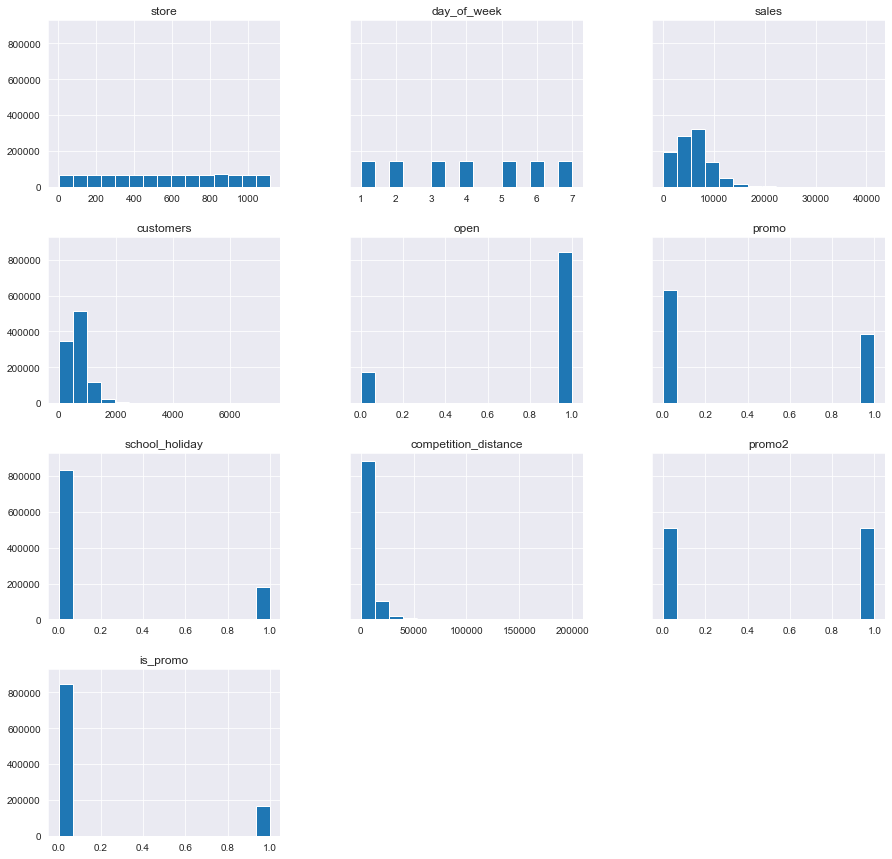

In [37]:
num_features.hist(figsize=(15,15), sharey=True, bins=15);

In [38]:
df5['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [39]:
df5['state_holiday'].value_counts()

regular_day       843428
public holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [40]:
df5['state_holiday']

0             regular_day
1             regular_day
2             regular_day
3             regular_day
4             regular_day
                ...      
1016776    public holiday
1016827    public holiday
1016863    public holiday
1017042    public holiday
1017190    public holiday
Name: state_holiday, Length: 844338, dtype: object

In [41]:
df5['state_holiday'].value_counts()

regular_day       843428
public holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

<AxesSubplot:xlabel='sales', ylabel='Density'>

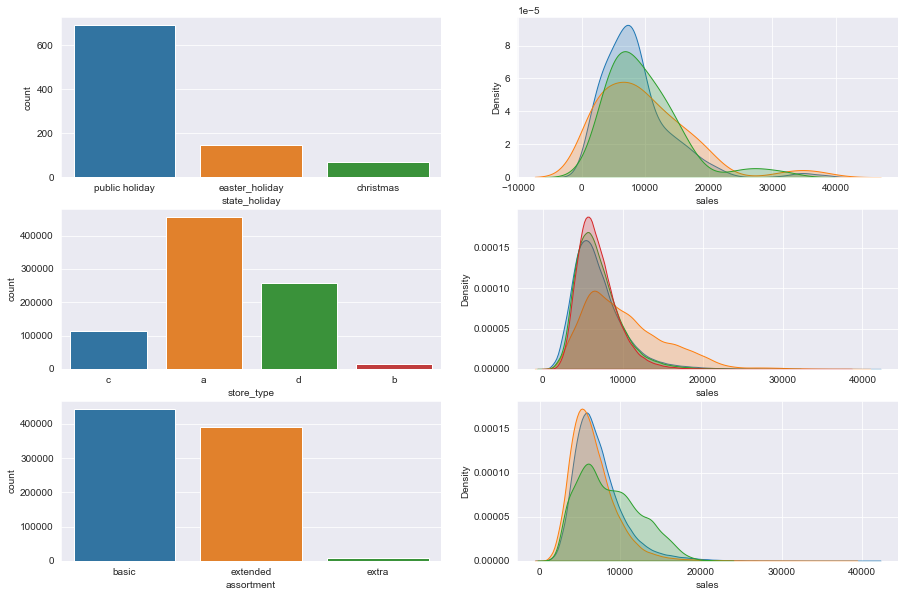

In [42]:
plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
sns.countplot(x=df5[df5['state_holiday'] != 'regular_day']['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

plt.subplot(3,2,3)
sns.countplot(x=df5['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', shade=True)

plt.subplot(3,2,5)
sns.countplot(x=df5['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], shade=True)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], shade=True)

In [43]:
#Análise Bivariada

### Validação de Hipóteses

<AxesSubplot:xlabel='year_week'>

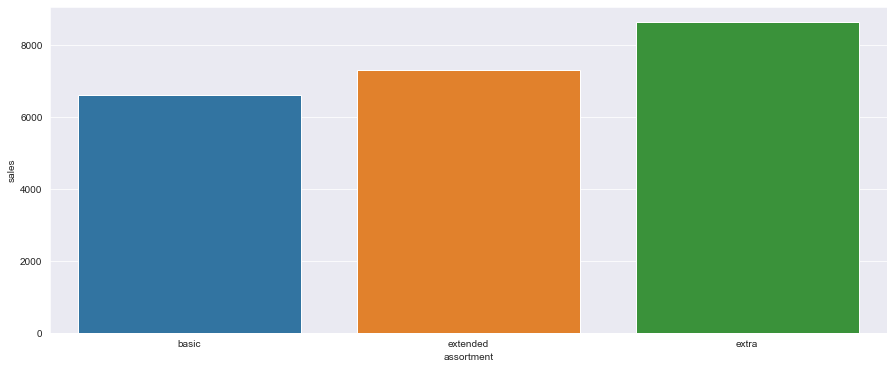

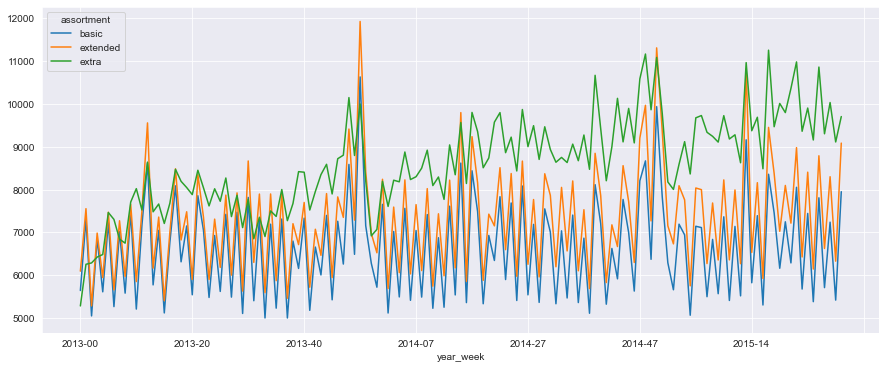

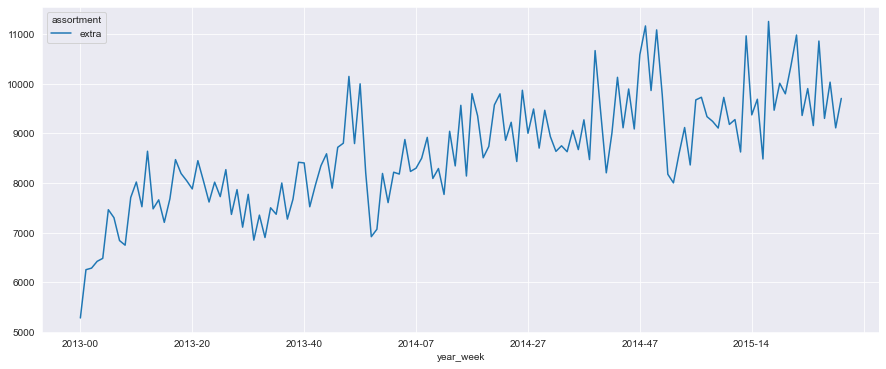

In [44]:
#1 Lojas com maior sortimentos vendem mais
#Falsa, lojas com maior sortimento vendem menos, conforme evidência abaixo:
#>>Verdadeiro, lojas com maior sortimento tendem a ter uma média de venda maior em relação à outras lojas

plt.figure(figsize=(15,6))
df_temp = df5[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=df_temp);

df_temp2 = df5[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
df_temp2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(15,6))

df_temp3 = df_temp2[df_temp2['assortment'] == 'extra']
df_temp3.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(15,6))

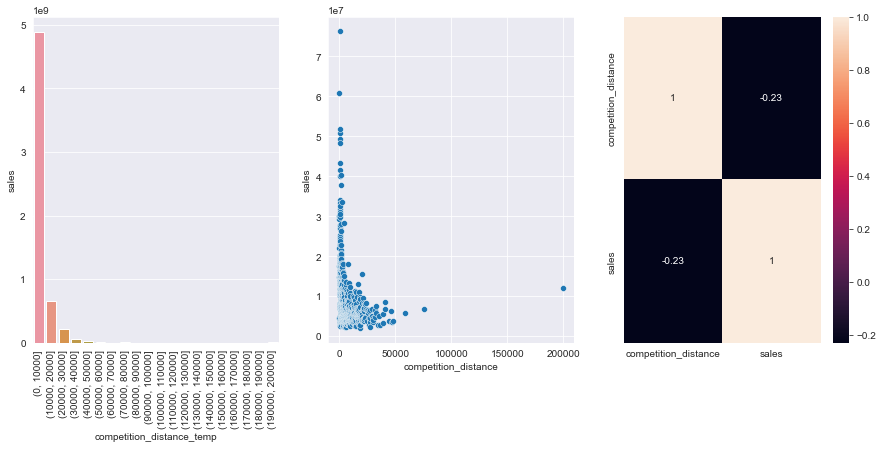

In [45]:
#2 Lojas com competidores mais próximos vendem menos
#Falsa, lojas com competidores mais próximos na verdade vendem mais.

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
df_temp = df5[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,200001,10000))
df_temp['competition_distance_temp'] = pd.cut(x=df_temp['competition_distance'], bins=bins)
df_temp2 = df_temp[['competition_distance_temp','sales']].groupby('competition_distance_temp').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_temp',y='sales',data=df_temp2)

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=df_temp);

plt.subplot(1,3,3)
sns.heatmap(df_temp.corr(method='pearson'), annot=True);

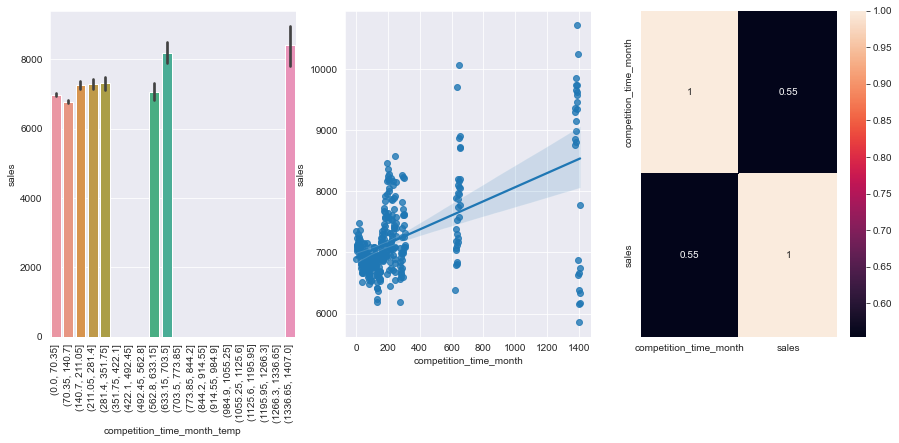

In [46]:
#3 Lojas com competidores há mais tempo vendem mais
#Falsa, lojas com competidores há mais tempo vendem menos
#>>>Verdadeiro, lojas com competidores há mais tempo tendem a vender mais
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
df_temp = df5[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
bins = np.arange(0,df5['competition_time_month'].max()+1,(df5['competition_time_month'].max())/20)
df_temp['competition_time_month_temp'] = pd.cut(df_temp['competition_time_month'], bins=bins)
sns.barplot(x='competition_time_month_temp', y='sales', data=df_temp);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
df_temp2 = df_temp[df_temp['competition_time_month'] > 0]
sns.regplot(x='competition_time_month', y='sales', data=df_temp2)

plt.subplot(1,3,3)
sns.heatmap(df_temp.corr(method='pearson'), annot=True);

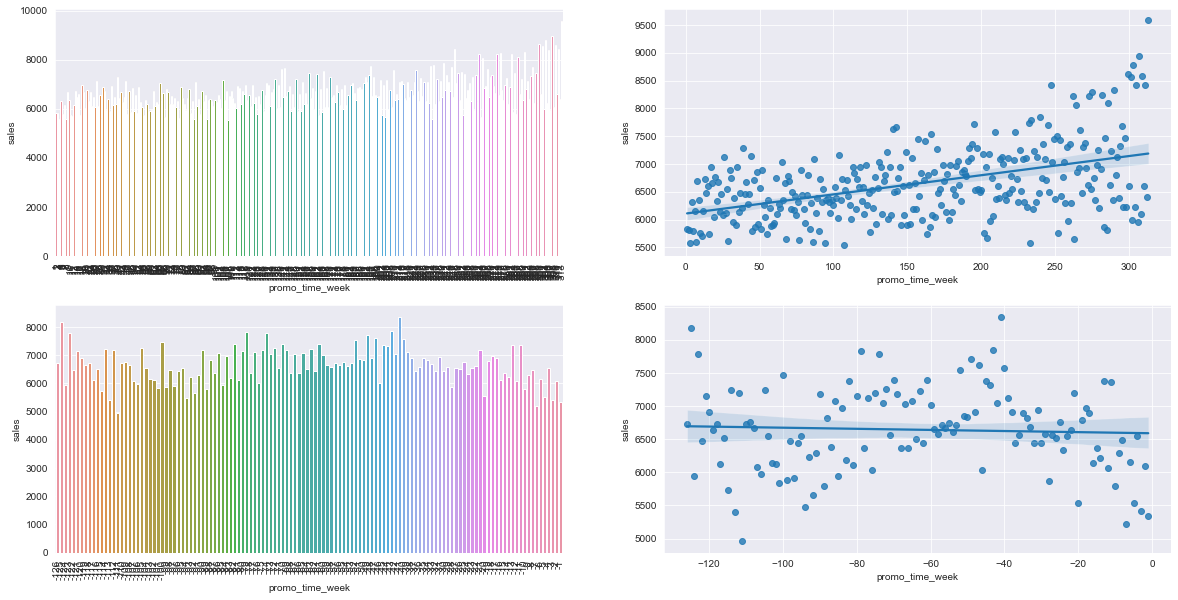

In [47]:
#4 Lojas com promoções ativas por mais tempo vendem mais
#Falsa, lojas com promoções ativas por mais tempo não necessariamente vendem mais
#>>Verdadeiro
df_temp = df5[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()
df_temp2 = df_temp[df_temp['promo_time_week'] > 0]
df_temp3 = df_temp[df_temp['promo_time_week'] < 0]

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(x='promo_time_week', y='sales', data=df_temp2)
plt.xticks(rotation=90)

plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=df_temp2)

plt.subplot(2,2,3)
sns.barplot(x='promo_time_week', y='sales', data=df_temp3)
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=df_temp3)
plt.show()

In [48]:
#<s>5 Lojas com mais dias de promoção vendem mais</s>

<Figure size 1080x432 with 0 Axes>

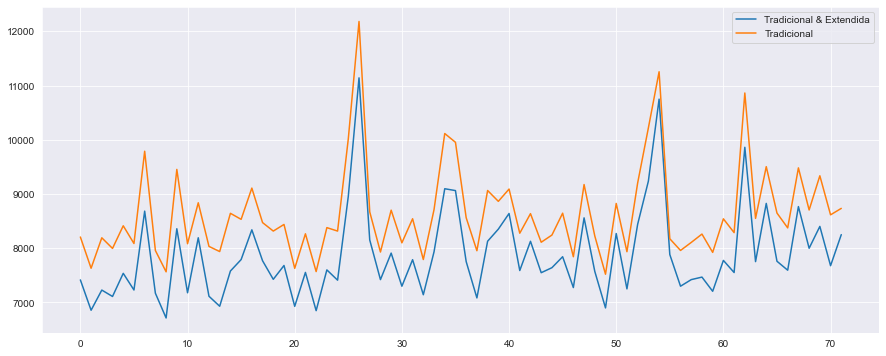

In [49]:
#6 Lojas com mais promocoes consecutivas vendem mais
#Falsa, lojas com promoções consecutivas vendem menos
plt.figure(figsize=(15,6))
df_temp = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = df_temp.plot(figsize=(15,6))
df_temp2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
df_temp2.plot(ax=ax)
plt.legend(['Tradicional & Extendida','Tradicional'])

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

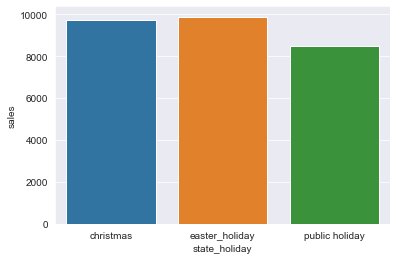

In [50]:
#7 Lojas abertas durante o feriado de natal vendem mais
#Falsa? Acredito que cabe utilizar .mean() ao invés de .sum()
#Falsa, o feriado campeão de venda é o easter_holiday, e não christmas
df_temp = df5[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
df_temp.drop(3, axis=0, inplace=True)
sns.barplot(x='state_holiday', y='sales', data=df_temp)


<AxesSubplot:>

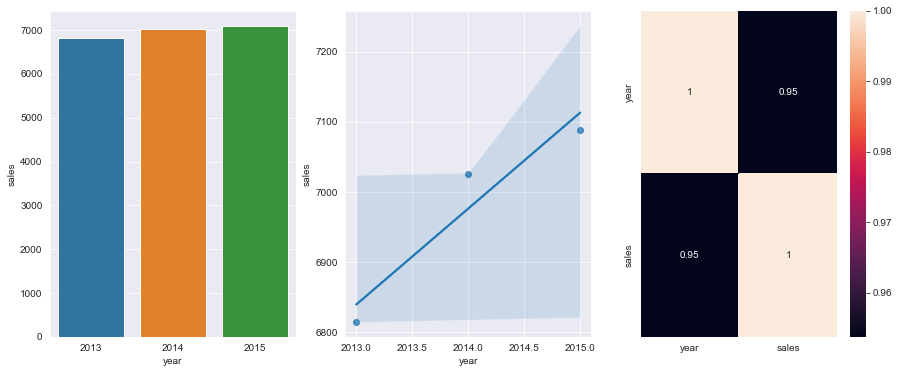

In [51]:
#8 Lojas vendem mais ao longo dos anos
#Falsa? Seria válido utilizar mean, visto que o ano de 2015 não está fechado
#Verdadeiro, o crescimento da loja cresce com o passar dos anos
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
df_temp = df5[['year','sales']].groupby('year').mean().reset_index()
sns.barplot(x='year', y='sales', data=df_temp)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df_temp)

plt.subplot(1,3,3)
sns.heatmap(df_temp.corr(method='pearson'), annot=True)

<AxesSubplot:>

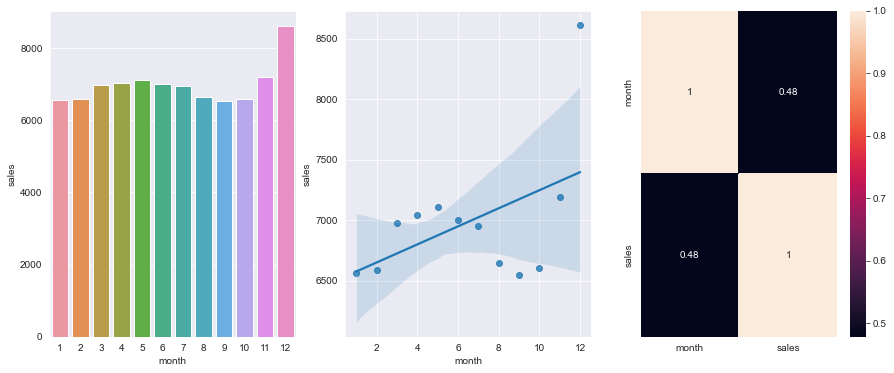

In [52]:
#9 Lojas devem vender mais no segundo semestre do ano
#Falsa? Acredito que pra validação correta seria cabivel utilizar mean também, como as demais.
#>>Verdadeiro, há um crescimento de vendas no segundo semestre do ano.
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
df_temp = df5[['month','sales']].groupby('month').mean().reset_index()
sns.barplot(x='month', y='sales', data=df_temp)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df_temp)

plt.subplot(1,3,3)
sns.heatmap(df_temp.corr(method='pearson'), annot=True)

<AxesSubplot:xlabel='date_period', ylabel='sales'>

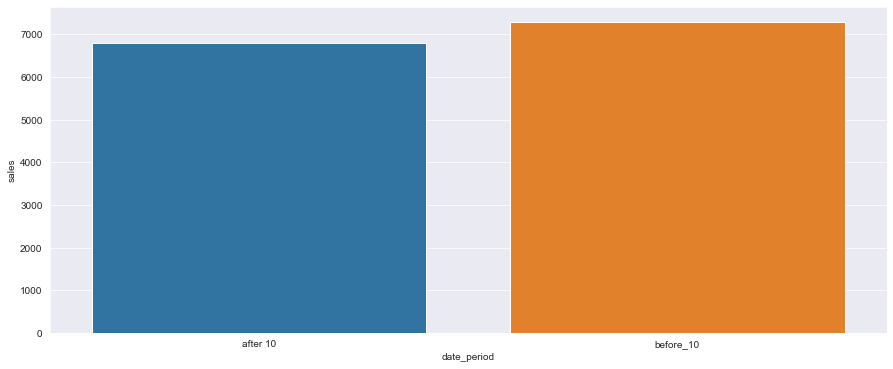

In [53]:
#10 Lojas devem vender mais depois do dia 10 de cada mês
#Falsa
plt.figure(figsize=(15,6))
df5['date_period'] = df5['day'].apply(lambda x: 'before_10' if x <= 10 else 'after 10')
df_temp = df5[['date_period','sales']].groupby('date_period').mean().reset_index()
sns.barplot(x='date_period', y='sales', data=df_temp)

<AxesSubplot:>

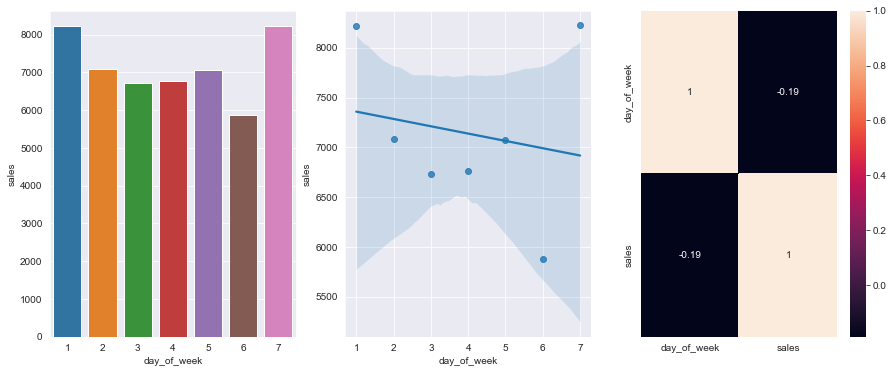

In [54]:
#11 Lojas devem vender menos aos finais de semana
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
df_temp = df5[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()
sns.barplot(x='day_of_week', y='sales', data=df_temp)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=df_temp)

plt.subplot(1,3,3)
sns.heatmap(df_temp.corr(method='pearson'), annot=True)

<AxesSubplot:xlabel='school_holiday', ylabel='sales'>

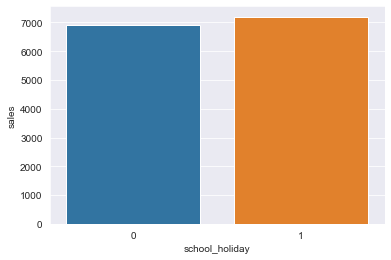

In [55]:
#12 Lojas devem vender menos durante os feriados escolares
#Falso
df_temp = df5[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
sns.barplot(x='school_holiday', y='sales', data=df_temp)

In [56]:
#Análise Multivariada

In [57]:
#Atributos categóricos
df_temp = df5.select_dtypes(include='object')

In [58]:
#CM = Tabela de contingencia (Confusion Matrix)
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

In [59]:
cramer_v(df_temp['state_holiday'], df_temp['store_type'])

0.07106469715258833

In [60]:
df_temp.drop(['year_week'], axis=1, inplace=True)


C:\Users\carli\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
a1 = cramer_v(df_temp['state_holiday'],df_temp['state_holiday'])
a2 = cramer_v(df_temp['state_holiday'],df_temp['store_type'])
a3 = cramer_v(df_temp['state_holiday'],df_temp['assortment'])

a4 = cramer_v(df_temp['store_type'],df_temp['state_holiday'])
a5 = cramer_v(df_temp['store_type'],df_temp['store_type'])
a6 = cramer_v(df_temp['store_type'],df_temp['assortment'])

a7 = cramer_v(df_temp['assortment'],df_temp['state_holiday'])
a8 = cramer_v(df_temp['assortment'],df_temp['store_type'])
a9 = cramer_v(df_temp['assortment'],df_temp['assortment'])

df_temp = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]
             })
df_temp.set_index(df_temp.columns)

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


In [62]:
df_temp

,state_holiday,store_type,assortment
0,1.000002,0.071065,0.067546
1,0.071065,1.000002,0.538457
2,0.067546,0.538457,1.000001


# 6. Preparação dos dados

In [63]:
df6 = df5.copy()

### Normalização

### Reescala

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df6['promo_time_week'] = mms.fit_transform(df6[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df6['year'] = mms.fit_transform(df6[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))




<AxesSubplot:>

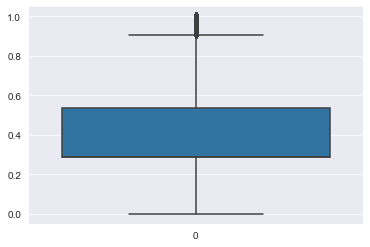

In [65]:
sns.boxplot(data=df6['promo_time_week'])

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

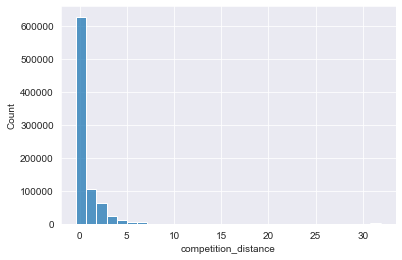

In [66]:
sns.histplot(data=df6['competition_distance'], bins=30)

### Transformação

#### Encoding

In [67]:
df6.head(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,date_period
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after 10
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after 10
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after 10
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after 10
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after 10


In [68]:
#state_holiday (Utilizado One Hot Encoding)
df6 = pd.get_dummies(df6,prefix=['state_holiday'], columns=['state_holiday'])

In [69]:
#store_type
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

In [70]:
#assortment
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

In [71]:
df6.head(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,year_week,competition_since,competition_time_month,promo_since,promo_time_week,date_period,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after 10,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after 10,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after 10,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after 10,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after 10,0,0,0,1


#### Response variable transformation

In [72]:
df6['sales'].head(5)

0     5263
1     6064
2     8314
3    13995
4     4822
Name: sales, dtype: int64

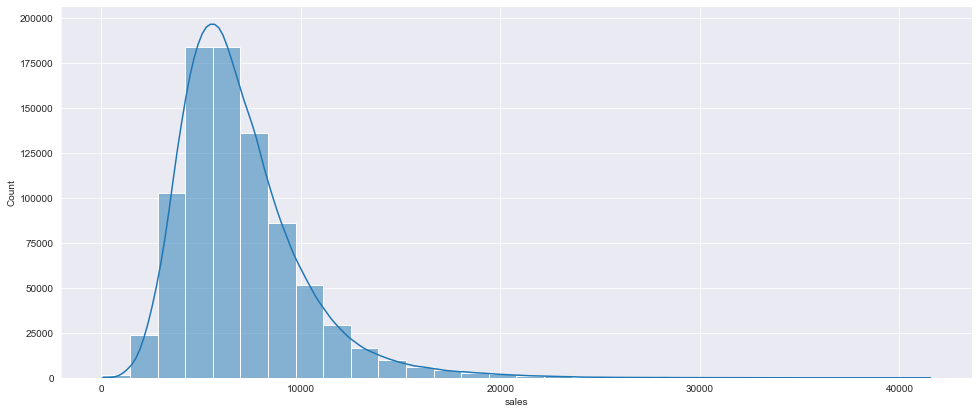

In [73]:
g1 = sns.displot(df6['sales'], bins=30, kde=True)
g1.fig.set_figwidth(16)
g1.fig.set_figheight(6)

In [74]:
df6['sales'] = np.log1p(df6['sales'])

In [75]:
df6['sales'].head(5)

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

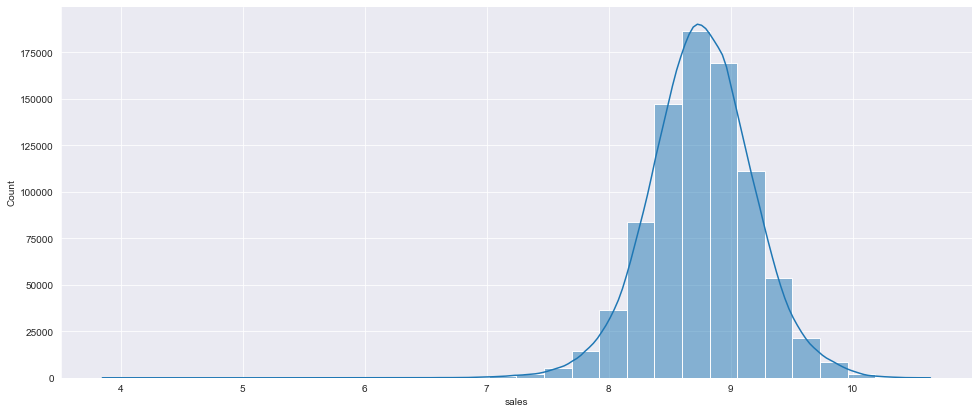

In [76]:
g1 = sns.displot(df6['sales'], bins=30, kde=True)
g1.fig.set_figwidth(16)
g1.fig.set_figheight(6)

####  Nature Transformation

In [77]:
#day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
#month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
#day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
#week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 7. Seleção de Features

In [78]:
df7 = df6.copy()

### Divisão do dataframe de teste e de treino

In [79]:
cols_drop = ['day_of_week','month','week_of_year','day','promo_since','competition_since','year_week','date_period']
df7 = df7.drop(cols_drop, axis=1)

In [80]:
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('\nTraining min date: {}'.format(X_test['date'].min()))
print('Training max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Training min date: 2015-06-19 00:00:00
Training max date: 2015-07-31 00:00:00


### Boruta Feature Selector

In [81]:
#Traning e Test dataset for Boruta
#X_train_n = X_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()
#
##Definições RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
##Definições Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### Best Features from Boruta

In [82]:
#cols_selected = boruta.support_.tolist()
#
##melhores features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
##not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### Manual Feature Selecting

In [83]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_sin']

feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8. Modelação do Aprendizado de Máquina

In [84]:
df8 = df7.copy()

In [85]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

### Average Model

In [86]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']
baseline_result = ml_error('Average Model',y_test, yhat_baseline) #Np.expm1 é utilizado para aplicar exponenciação (que é o oposto de logarítmo) e retornar o Sales ao valor original
baseline_result

{'Model name': 'Average Model',
 'MAE': 2498.8015098151654,
 'MAPE': 0.3986633507615099,
 'RMSE': 3650.1670485350865}

### Linear Regression Model 

In [87]:
lr = LinearRegression().fit(x_train, y_train)
yhat_lr = lr.predict(x_test)
lr_result = ml_error('Linear Regression', y_test, yhat_lr)
lr_result

{'Model name': 'Linear Regression',
 'MAE': 1867.0897737576713,
 'MAPE': 0.28193271924493357,
 'RMSE': 2671.0492151383305}

### Linear Regression Model - CV

In [88]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

{'Model Name': 'Linear Regression',
 'MAE CV': '2081.73 +/- 295.63',
 'MAPE CV': '0.31 +/- 0.04',
 'RMSE CV': '2952.52 +/- 468.37'}

### Linear Regression Regularized Model - Lasso

In [89]:
lrr = Lasso(alpha=0.01).fit(x_train, y_train)
yhat_lrr = lrr.predict(x_test)
lrr_result = ml_error('Linear Regression Lasso', y_test, yhat_lrr)
lrr_result

{'Model name': 'Linear Regression Lasso',
 'MAE': 1891.704880507952,
 'MAPE': 0.2918152734420607,
 'RMSE': 2744.4517370494777}

### Linear Regression Regularized Model - Lasso - CV

In [90]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

{'Model Name': 'Lasso',
 'MAE CV': '2116.38 +/- 341.5',
 'MAPE CV': '0.33 +/- 0.05',
 'RMSE CV': '3057.75 +/- 504.26'}

### Random Forest Regressor

In [91]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42).fit(x_train, y_train)
yhat_rf = rf.predict(x_test)
rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)
rf_result

{'Model name': 'Random Forest Regressor',
 'MAE': 678.3905399950113,
 'MAPE': 0.09769091775939823,
 'RMSE': 1008.8857142689876}

### Random Forest Regressor - CV

In [92]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf)
rf_result_cv

{'Model Name': 'Random Forest Regressor',
 'MAE CV': '837.94 +/- 218.37',
 'MAPE CV': '0.12 +/- 0.02',
 'RMSE CV': '1257.46 +/- 319.24'}

### XGBoost Regressor

In [93]:
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)
yhat_xgb = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', y_test, yhat_xgb)
xgb_result

{'Model name': 'XGBoost Regressor',
 'MAE': 868.9582052729373,
 'MAPE': 0.12765883798540395,
 'RMSE': 1238.5508430376537}

### XGBoost Regressor - CV

In [94]:
xgb_result_cv = cross_validation(x_training, 5, 'XGB Regressor', model_xgb)
xgb_result_cv

{'Model Name': 'XGB Regressor',
 'MAE CV': '1063.87 +/- 176.82',
 'MAPE CV': '0.15 +/- 0.02',
 'RMSE CV': '1518.64 +/- 240.02'}

### Module Comparison

In [95]:
modelling_result = pd.concat([pd.DataFrame([baseline_result]), pd.DataFrame([lr_result]), pd.DataFrame([lrr_result]), pd.DataFrame([rf_result]), pd.DataFrame([xgb_result])])
modelling_result.sort_values('RMSE')

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.390540,0.097691,1008.885714
0,XGBoost Regressor,868.958205,0.127659,1238.550843
0,Linear Regression,1867.089774,0.281933,2671.049215
0,Linear Regression Lasso,1891.704881,0.291815,2744.451737
0,Average Model,2498.801510,0.398663,3650.167049


### Module Comparison - CV

In [96]:
modelling_result_cv = pd.concat([pd.DataFrame([lr_result_cv]), pd.DataFrame([lrr_result_cv]), pd.DataFrame([rf_result_cv]), pd.DataFrame([xgb_result_cv])])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.94 +/- 218.37,0.12 +/- 0.02,1257.46 +/- 319.24
0,XGB Regressor,1063.87 +/- 176.82,0.15 +/- 0.02,1518.64 +/- 240.02
0,Linear Regression,2081.73 +/- 295.63,0.31 +/- 0.04,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.33 +/- 0.05,3057.75 +/- 504.26


# 9. Hyperparameter Fine Tuning

In [97]:
df9 = df8.copy()

### Random Search

In [98]:
#param = {
#    'n_estimators':[100,500,1500],
#    'eta':[0.01, 0.05, 0.10],
#    'max_depth':[3,6,10],
#    'subsample':[0.1,0.5,1],
#    'colsample_bytree':[0.5,1],
#    'min_child_weight':[3,8,15],
#}
#max_eval = 5

In [99]:
#final_result = pd.DataFrame()
#for i in range(max_eval):
#    #Escolhendo valores aleatóriamente
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(i+1, hp)
#    model_xgb = xgb.XGBRegressor(n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight']).fit(x_training, y_train)
#    result = pd.DataFrame(cross_validation(x_training, 5, model_xgb), index=[i+1])
#    final_result = pd.concat([final_result, result])
#final_result

### Final Model

In [100]:
tuned_param = {
    'n_estimators':500,
    'eta':0.01,
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.5,
    'min_child_weight':8,
}
#tuned_param = {
#    'n_estimators':1500,
#    'eta':0.01,
#    'max_depth':10,
#    'subsample':1,
#    'colsample_bytree':0.5,
#    'min_child_weight':8,
#}
#{'Model name': 'Tuned XGBoost Regressor',
# 'MAE': 768.5159483480273,
# 'MAPE': 0.1128595978632495,
# 'RMSE': 1114.9098046481945}

In [101]:
tuned_model_xgb = xgb.XGBRegressor(n_estimators=tuned_param['n_estimators'],
                             eta=tuned_param['eta'],
                             max_depth=tuned_param['max_depth'],
                             subsample=tuned_param['subsample'],
                             colsample_bytree=tuned_param['colsample_bytree'],
                             min_child_weight=tuned_param['min_child_weight']).fit(x_train, y_train)
tuned_yhat_xgb = tuned_model_xgb.predict(x_test)
tuned_xgb_result = ml_error('Tuned XGBoost Regressor', y_test, tuned_yhat_xgb)
tuned_xgb_result

{'Model name': 'Tuned XGBoost Regressor',
 'MAE': 1438.924970055677,
 'MAPE': 0.2219015345643713,
 'RMSE': 2122.1413832267967}

In [102]:
#pickle.dump(tuned_model_xgb, open('model/model_rossmann.pkl', 'wb'))

In [103]:
mpe = np.sum((np.expm1(y_test) - np.expm1(tuned_yhat_xgb))/np.expm1(tuned_yhat_xgb))/len(tuned_yhat_xgb)
mpe

0.09479872071392637

# 10. Tradução e Interpretração do erro

In [104]:
pd.options.mode.chained_assignment = None  # Desabilitar aviso
df10 = X_test[cols_selected_boruta_full]
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1(tuned_yhat_xgb)


### Business Performance

In [105]:
#Soma das predições
###Esse método está certo? Por que? O mae está dando um valor muito baixo para o total de predições. Um outro ponto é que o valor do MAE não representa o valor do MAPE em relação a variável prevista (sales)
df10_1 = df10[['store','predictions','sales']].groupby('store').sum().reset_index()

#MAE e MAPE
df10_aux1 = df10[['store','sales','predictions']].groupby('store').apply(lambda x: (np.sum(np.abs((x['sales']) - (x['predictions']))))/len(x['predictions'])).reset_index()
df10_aux2 = df10[['store','sales','predictions']].groupby('store').apply(lambda x: (np.sum(np.abs((x['sales']) - (x['predictions']))/(x['predictions']))/len(x['predictions']))).reset_index()
df10_aux1.columns = ['store','MAE']
df10_aux2.columns = ['store','MAPE']
df10_aux3 = pd.merge(df10_aux1, df10_aux2, how='inner', on='store')
df10_2 = pd.merge(df10_1, df10_aux3, how='inner', on='store')
df10_2

,store,predictions,sales,MAE,MAPE
0,1,196969.265625,162320.0,936.466757,0.173980
1,2,182116.281250,182936.0,501.829986,0.105545
2,3,221497.250000,254190.0,929.978087,0.155741
3,4,281415.968750,369378.0,2377.352288,0.314947
4,5,168168.140625,166905.0,431.146636,0.101891
...,...,...,...,...,...
1110,1111,191284.796875,173854.0,834.288653,0.156441
1111,1112,286848.750000,319237.0,1156.310771,0.145586
1112,1113,248969.593750,243427.0,579.890190,0.085168
1113,1114,603617.250000,842724.0,6462.345043,0.392245


In [106]:
df10[['store','predictions','sales']].groupby('store').sum().reset_index()

,store,predictions,sales
0,1,196969.265625,162320.0
1,2,182116.281250,182936.0
2,3,221497.250000,254190.0
3,4,281415.968750,369378.0
4,5,168168.140625,166905.0
...,...,...,...
1110,1111,191284.796875,173854.0
1111,1112,286848.750000,319237.0
1112,1113,248969.593750,243427.0
1113,1114,603617.250000,842724.0


In [107]:
#Somando todos os valores e criando uma coluna auxiliar de contagem para cálculo do MAE. 
###Esse método está errado? Por que?
df_aux4 = df10[['store','sales','predictions']].groupby('store').sum().reset_index()
df_aux5 = pd.DataFrame(df10['store'].value_counts().reset_index())
df_aux5.columns = (['store','count'])
df10_3 = pd.merge(df_aux4, df_aux5, how='inner', on='store')
df10_3['MAE'] = df10_3.apply(lambda x: (np.abs(x['sales']-x['predictions'])), axis=1)
df10_3['MAPE'] = df10_3.apply(lambda x: ((np.abs(x['sales'] - x['predictions'])/x['sales'])), axis=1)
df10_3

,store,sales,predictions,count,MAE,MAPE
0,1,162320.0,196969.265625,37,34649.265625,0.213463
1,2,182936.0,182116.281250,37,819.718750,0.004481
2,3,254190.0,221497.250000,37,32692.750000,0.128615
3,4,369378.0,281415.968750,37,87962.031250,0.238136
4,5,166905.0,168168.140625,37,1263.140625,0.007568
...,...,...,...,...,...,...
1110,1111,173854.0,191284.796875,37,17430.796875,0.100261
1111,1112,319237.0,286848.750000,37,32388.250000,0.101455
1112,1113,243427.0,248969.593750,37,5542.593750,0.022769
1113,1114,842724.0,603617.250000,37,239106.750000,0.283731


In [108]:
#Scenarios
df10_2['worst_scenario'] = df10_2['predictions'] - df10_2['MAE']
df10_2['best_scenario'] = df10_2['predictions'] + df10_2['MAE']
df10_2 = df10_2[['store','predictions','MAE','worst_scenario','best_scenario','MAPE']]
df10_2.sample(5)

,store,predictions,MAE,worst_scenario,best_scenario,MAPE
425,426,234957.921875,1499.322081,233458.599794,236457.243956,0.236936
916,917,214293.828125,787.947780,213505.880345,215081.775905,0.134953
719,720,234759.156250,987.580712,233771.575538,235746.736962,0.161439
377,378,255724.906250,625.640335,255099.265915,256350.546585,0.091169
349,350,216804.312500,1364.652608,215439.659892,218168.965108,0.230829


In [109]:
df10_2.sort_values('MAPE',ascending=False).head()

,store,predictions,MAE,worst_scenario,best_scenario,MAPE
841,842,282914.84375,12723.842074,270191.001676,295638.685824,1.677173
697,698,251974.28125,9995.560138,241978.721112,261969.841388,1.503902
908,909,162473.81250,9390.186099,153083.626401,171863.998599,1.500666
787,788,297741.18750,9612.157385,288129.030115,307353.344885,1.202492
512,513,309211.43750,8675.339897,300536.097603,317886.777397,1.083873


<AxesSubplot:xlabel='store', ylabel='MAPE'>

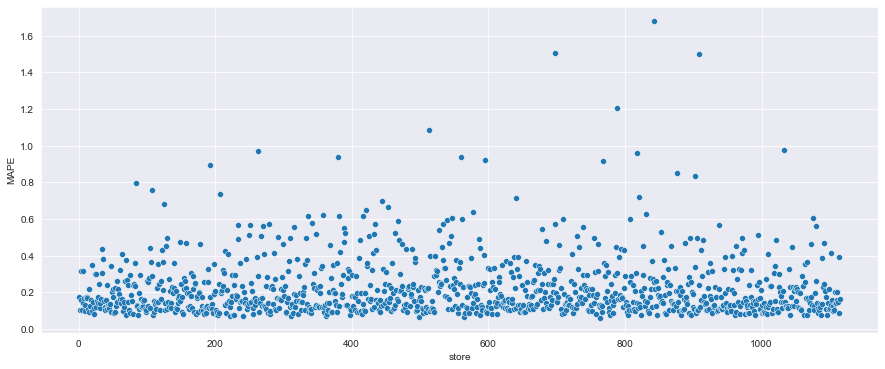

In [110]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='store',y='MAPE',data=df10_2)

### Total performance

In [111]:
df10_4 = df10_2[['predictions','worst_scenario','best_scenario']].sum().reset_index().rename(columns={'index':'Scenario',0:'Values'})
df10_4['Values'] = df10_4['Values'].map('U${:,.2f}'.format)
df10_4

,Scenario,Values
0,predictions,"U$259,537,024.00"
1,worst_scenario,"U$257,931,854.24"
2,best_scenario,"U$261,142,194.32"


### Machine Learning Performance

In [112]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions']/df10['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

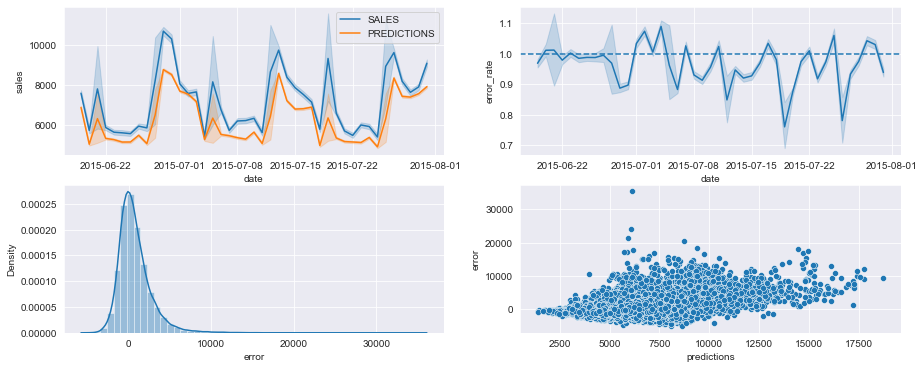

In [113]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df10, label='SALES')
sns.lineplot(x='date', y='predictions', data=df10, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df10)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df10['error'])

plt.subplot(2,2,4)
sns.scatterplot(df10['predictions'],df10['error'])

# 11. Deploy do modelo para produção

In [114]:
pickle.dump(tuned_model_xgb, open('model/model_rossmann.pkl', 'wb'))

### Rossmann Class

In [115]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df2):
        snakecase = lambda x: inflection.underscore(x)
        df2.columns = list(map(snakecase, df2.columns))
        df2['date'] = pd.to_datetime(df2['date'])
        df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        df2['promo2_since_week'] = df2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        df2['promo2_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        calendar = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df2['promo_interval'].fillna(0, inplace=True)
        df2['calendar'] = df2['date'].dt.month.map(calendar)
        df2['is_promo'] = df2[['promo_interval','calendar']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['calendar'] in x['promo_interval'].split(',') else 0, axis=1)        
        df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
        df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
        df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
        df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)        
        return df2
    
    def feature_engineering(self,df3):
        df3['year'] = df3['date'].dt.year
        df3['month'] = df3['date'].dt.month
        df3['day'] = df3['date'].dt.day
        df3['week_of_year'] = df3['date'].dt.isocalendar().week
        df3['year_week'] = df3['date'].dt.strftime('%Y-%W')
        df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df3['competition_time_month'] = ((df3['date'] - df3['competition_since'])/30).apply(lambda x: x.days).astype(int)
        df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
        df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
        df3['promo_time_week'] = ((df3['date'] - df3['promo_since'])/7).apply(lambda x: x.days).astype(int)
        df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
        df3.drop(['customers','open','promo_interval','calendar'], axis=1, inplace=True)
        return df3
    
    def data_preparation(self,df6):
        df6['competition_distance'] = self.cometition_distance_scaler.transform(df6[['competition_distance']].values)
        df6['competition_time_month'] = self.competition_time_month.transform(df6[['competition_time_month']].values)
        df6['promo_time_week'] = self.promo_time_week.transform(df6[['promo_time_week']].values)
        df6['year'] = self.transform(df6[['year']].values)
        df6 = pd.get_dummies(df6,prefix=['state_holiday'], columns=['state_holiday'])
        df6['store_type'] = self.store_type_scaler.transform(df6['store_type'])
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df6['assortment'] = df6['assortment'].map(assortment_dict)
        df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
        df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance',
                                'competition_open_since_month','competition_open_since_year',
                                'promo2','promo2_since_week','promo2_since_year',
                                'competition_time_month','promo_time_week','day_of_week_sin',
                                'day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                                'week_of_year_cos','week_of_year_sin']
        
        return df6[cols_selected]

### API Handler

In [116]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:\\Users\\carli\\Documents\\#Python\\Comunidade DS\\repos\\ds_em_producao\\model\\model_rossmann.pkl', 'rb'))


app = Flask(__name__)
@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    if test_json: #Se houver dados
        
        if isinstance(test_json, dict): #Linha única
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #Múltiplas linhas
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        #Instantiate Rossmann Class
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #predictions
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else: #Se não houver dados
        return Response('{}', status=200, minetype='application/json')

if __name__ == '__main__':
    app.run('192.168.3.6')

ModuleNotFoundError: No module named 'rossmann'

### API Tester

In [ ]:
df11 = pd.read_csv('./data/test.csv')
store_list = [7, 15, 12, 24]

#Merge test.csv + store.csv
df_test = pd.merge(df11, df_store, how='left', on='Store')

#Choose store for prediction
df_test = df_test[df_test['Store'].isin(store_list)]

#Remove closed store days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

#Convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))


In [ ]:
#API Call
#url = '0.0.0.0:5000/rossmann/predict'
url = '192.168.3.6:5000/rossmann/predict'
#url = 'http://rossmann-predmodel.herokuapp.com/rossmann/predict' #Pra onde vou enviar esse pedido?
header = {'Content-type':'application/json'} #Indica que tipo de dado a API esta recebendo
data = data #Dado

r = requests.post(url, data=data, headers=header) #Método .post, onde envio um dado para fazer um pedido
print('Status code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Store {} will sell {:,.2f} in next 6 weeks.'.format(d2.loc[i,'store'],d2.loc[i,'prediction']))